# Chapter 13: Performance Metrics

## Creating the Prophet performance metrics DataFrame

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

c:\users\gregr\appdata\local\programs\python\python38\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


10:22:56 - cmdstanpy - INFO - Chain [1] start processing
10:22:57 - cmdstanpy - INFO - Chain [1] done processing


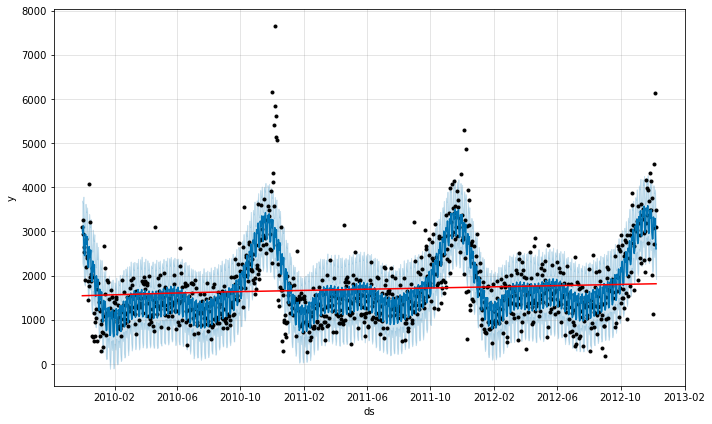

In [2]:
df = pd.read_csv('../data/online_retail.csv')
df.columns = ['ds', 'y']

model = Prophet(yearly_seasonality=4)
model.fit(df)
forecast = model.predict()
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

In [3]:
df_cv = cross_validation(model,
                         horizon='90 days',
                         period='30 days',
                         initial='730 days',
                         parallel='processes')

In [4]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,221704.895762,470.855494,379.414818,0.300655,0.232036,0.258492,0.855556
1,10 days,218301.274098,467.227219,375.346650,0.297784,0.222543,0.256136,0.866667
2,11 days,203136.619350,450.706800,368.737029,0.288051,0.202973,0.251314,0.888889
3,12 days,179255.608023,423.385885,350.886177,0.273845,0.206923,0.241071,0.922222
4,13 days,173081.376913,416.030500,344.705049,0.260914,0.192008,0.234395,0.933333


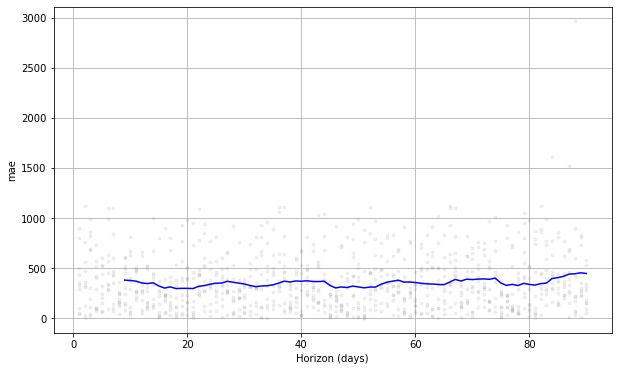

In [5]:
fig = plot_cross_validation_metric(df_cv, metric='mae')
plt.show()

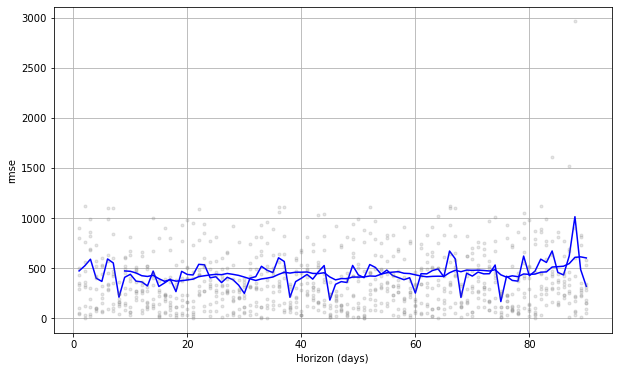

In [6]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
plot_cross_validation_metric(df_cv,
                             metric='rmse',
                             rolling_window=.01,
                             ax=ax)
plot_cross_validation_metric(df_cv,
                             metric='rmse',
                             rolling_window=.1,
                             ax=ax)
plt.show()

## Handling irregular cut-offs

10:23:19 - cmdstanpy - INFO - Chain [1] start processing
10:23:19 - cmdstanpy - INFO - Chain [1] done processing


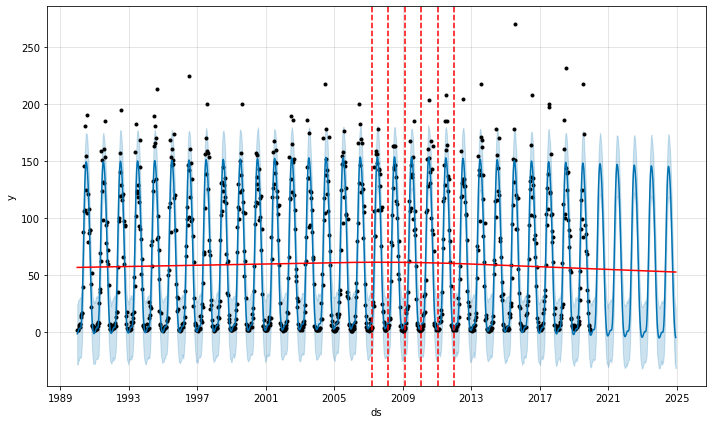

In [7]:
df = pd.read_csv('../data/rainfall.csv')
df.columns = ['ds', 'y']

model = Prophet(yearly_seasonality=4)
model.fit(df)
future = model.make_future_dataframe(periods=365 * 5)
future = future[future['ds'].dt.day.isin([1, 11, 21])]
forecast = model.predict(future)
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

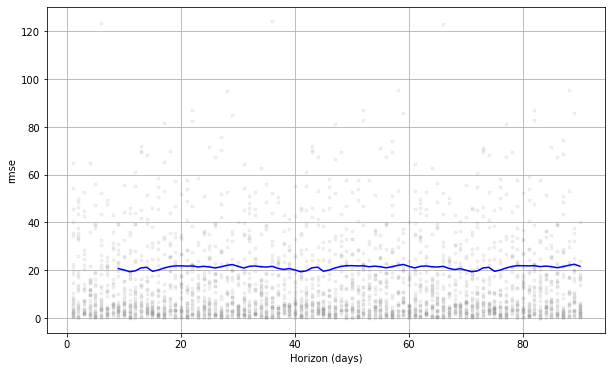

In [8]:
df_cv = cross_validation(model,
                         horizon='90 days',
                         period='30 days',
                         initial='1826 days',
                         parallel='processes')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='rmse')
plt.show()

In [9]:
cutoffs = [pd.Timestamp('{}-{}-{}'.format(year, month, day))
           for year in range(2005, 2019)
           for month in range(1, 13)
           for day in [1, 11, 21]]

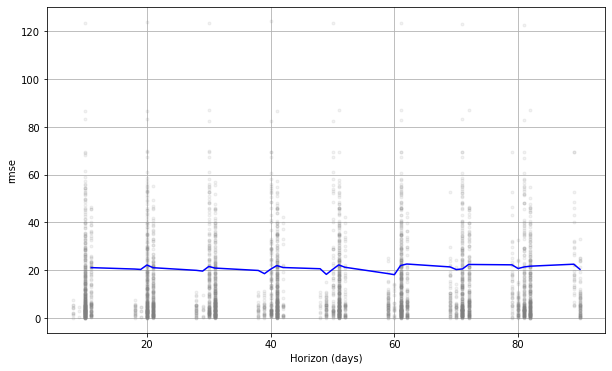

In [10]:
df_cv = cross_validation(model,
                         horizon='90 days',
                         parallel='processes',
                         cutoffs=cutoffs)
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='rmse')
plt.show()

## Tuning hyperparameters with grid search

In [11]:
param_grid = {'changepoint_prior_scale': [0.5, 0.1, 0.01, 0.001],
              'seasonality_prior_scale': [10.0, 1.0, 0.1, 0.01],
              'seasonality_mode': ['additive', 'multiplicative']}

In [12]:
import numpy as np
import itertools

all_params = [dict(zip(param_grid.keys(), value))
              for value in itertools.product(*param_grid.values())]
rmse_values= []

In [13]:
cutoffs = [pd.Timestamp('{}-{}-{}'.format(year, month, day))
           for year in range(2010, 2019)
           for month in range(1, 13)
           for day in [1, 11, 21]]

In [14]:
for params in all_params:
    model = Prophet(yearly_seasonality=4, **params).fit(df)
    df_cv = cross_validation(model,
                             cutoffs=cutoffs,
                             horizon='30 days',
                             parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmse_values.append(df_p['rmse'].values[0])

10:38:07 - cmdstanpy - INFO - Chain [1] start processing
10:38:07 - cmdstanpy - INFO - Chain [1] done processing
10:43:59 - cmdstanpy - INFO - Chain [1] start processing
10:44:00 - cmdstanpy - INFO - Chain [1] done processing
10:49:04 - cmdstanpy - INFO - Chain [1] start processing
10:49:04 - cmdstanpy - INFO - Chain [1] done processing
10:51:09 - cmdstanpy - INFO - Chain [1] start processing
10:51:09 - cmdstanpy - INFO - Chain [1] done processing
10:53:27 - cmdstanpy - INFO - Chain [1] start processing
10:53:27 - cmdstanpy - INFO - Chain [1] done processing
10:55:29 - cmdstanpy - INFO - Chain [1] start processing
10:55:30 - cmdstanpy - INFO - Chain [1] done processing
10:57:43 - cmdstanpy - INFO - Chain [1] start processing
10:57:43 - cmdstanpy - INFO - Chain [1] done processing
10:59:44 - cmdstanpy - INFO - Chain [1] start processing
10:59:44 - cmdstanpy - INFO - Chain [1] done processing
11:01:43 - cmdstanpy - INFO - Chain [1] start processing
11:01:43 - cmdstanpy - INFO - Chain [1]

In [15]:
results = pd.DataFrame(all_params)
results['rmse'] = rmse_values
results.head()

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
0,0.5,10.0,additive,22.622655
1,0.5,10.0,multiplicative,23.049950
2,0.5,1.0,additive,22.624643
3,0.5,1.0,multiplicative,23.049064
4,0.5,0.1,additive,22.631069


In [16]:
best_params = all_params[np.argmin(rmse_values)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive'}
